#### Asynchronous Advantage Actor Critic (A3C) algorithm

#### Network

In [22]:
#import
import gym
import sys
import os
import numpy as np
import tensorflow as tf
import threading
import time
import multiprocessing
import itertools
import matplotlib.pyplot as plt
import shutil

In [23]:
#method
def build_feature_extractor(input_):
  # We only want to create the weights once
  # In all future calls we should set reuse = True

  # scale the inputs from 0..255 to 0..1
  input_ = tf.to_float(input_) / 255.0

  # conv layers
  conv1 = tf.contrib.layers.conv2d(
    input_,
    16, # num output feature maps
    8,  # kernel size
    4,  # stride
    activation_fn=tf.nn.relu,
    scope="conv1")
  conv2 = tf.contrib.layers.conv2d(
    conv1,
    32, # num output feature maps
    4,  # kernel size
    2,  # stride
    activation_fn=tf.nn.relu,
    scope="conv2")

  # image -> feature vector
  flat = tf.contrib.layers.flatten(conv2)

  # dense layer
  fc1 = tf.contrib.layers.fully_connected(
    inputs=flat,
    num_outputs=256,
    scope="fc1")

  return fc1

In [24]:
#Class Policy Network
class PolicyNetwork:
  def __init__(self, num_outputs, reg=0.01):
    self.num_outputs = num_outputs

    # Graph inputs
    # After resizing we have 4 consecutive frames of size 84 x 84
    self.states = tf.placeholder(shape=[None, 84, 84, 4], dtype=tf.uint8, name="X")
    # Advantage = G - V(s)
    self.advantage = tf.placeholder(shape=[None], dtype=tf.float32, name="y")
    # Selected actions
    self.actions = tf.placeholder(shape=[None], dtype=tf.int32, name="actions")

    # Since we set reuse=False here, that means we MUST
    # create the PolicyNetwork before creating the ValueNetwork
    # ValueNetwork will use reuse=True
    with tf.variable_scope("shared", reuse=False):
      fc1 = build_feature_extractor(self.states)

    # Use a separate scope for output and loss
    with tf.variable_scope("policy_network"):
      self.logits = tf.contrib.layers.fully_connected(fc1, num_outputs, activation_fn=None)
      self.probs = tf.nn.softmax(self.logits)

      # Sample an action
      cdist = tf.distributions.Categorical(logits=self.logits)
      self.sample_action = cdist.sample()

      # Add regularization to increase exploration
      self.entropy = -tf.reduce_sum(self.probs * tf.log(self.probs), axis=1)

      # Get the predictions for the chosen actions only
      batch_size = tf.shape(self.states)[0]
      gather_indices = tf.range(batch_size) * tf.shape(self.probs)[1] + self.actions
      self.selected_action_probs = tf.gather(tf.reshape(self.probs, [-1]), gather_indices)

      self.loss = tf.log(self.selected_action_probs) * self.advantage + reg * self.entropy
      self.loss = -tf.reduce_sum(self.loss, name="loss")

      # training
      self.optimizer = tf.train.RMSPropOptimizer(0.00025, 0.99, 0.0, 1e-6)

      # we'll need these later for running gradient descent steps
      self.grads_and_vars = self.optimizer.compute_gradients(self.loss)
      self.grads_and_vars = [[grad, var] for grad, var in self.grads_and_vars if grad is not None]

In [25]:
#Class Value Network
class ValueNetwork:
  def __init__(self):
    # Placeholders for our input
    # After resizing we have 4 consecutive frames of size 84 x 84
    self.states = tf.placeholder(shape=[None, 84, 84, 4], dtype=tf.uint8, name="X")
    # The TD target value
    self.targets = tf.placeholder(shape=[None], dtype=tf.float32, name="y")

    # Since we set reuse=True here, that means we MUST
    # create the PolicyNetwork before creating the ValueNetwork
    # PolictyNetwork will use reuse=False
    with tf.variable_scope("shared", reuse=True):
      fc1 = build_feature_extractor(self.states)

    # Use a separate scope for output and loss
    with tf.variable_scope("value_network"):
      self.vhat = tf.contrib.layers.fully_connected(
        inputs=fc1,
        num_outputs=1,
        activation_fn=None)
      self.vhat = tf.squeeze(self.vhat, squeeze_dims=[1], name="vhat")

      self.loss = tf.squared_difference(self.vhat, self.targets)
      self.loss = tf.reduce_sum(self.loss, name="loss")

      # training
      self.optimizer = tf.train.RMSPropOptimizer(0.00025, 0.99, 0.0, 1e-6)

      # we'll need these later for running gradient descent steps
      self.grads_and_vars = self.optimizer.compute_gradients(self.loss)
      self.grads_and_vars = [[grad, var] for grad, var in self.grads_and_vars if grad is not None]

In [26]:
# Should use this to create networks
# to ensure they're created in the correct order
def create_networks(num_outputs):
  policy_network = PolicyNetwork(num_outputs=num_outputs)
  value_network = ValueNetwork()
  return policy_network, value_network

#### Worker

In [27]:
#class
class Step:
  def __init__(self, state, action, reward, next_state, done):
    self.state = state
    self.action = action
    self.reward = reward
    self.next_state = next_state
    self.done = done

##### Transform raw images for input into neural network
 1) Convert to grayscale
 2) Resize
 3) Crop

In [28]:
#Transformer
class ImageTransformer:
  def __init__(self):
    with tf.variable_scope("image_transformer"):
      self.input_state = tf.placeholder(shape=[210, 160, 3], dtype=tf.uint8)
      self.output = tf.image.rgb_to_grayscale(self.input_state)
      self.output = tf.image.crop_to_bounding_box(self.output, 34, 0, 160, 160)
      self.output = tf.image.resize_images(
        self.output,
        [84, 84],
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
      self.output = tf.squeeze(self.output)

  def transform(self, state, sess=None):
    sess = sess or tf.get_default_session()
    return sess.run(self.output, { self.input_state: state })

In [29]:
# Create initial state by repeating the same frame 4 times
def repeat_frame(frame):
  return np.stack([frame] * 4, axis=2)


# Create next state by shifting each frame by 1
# Throw out the oldest frame
# And concatenate the newest frame
def shift_frames(state, next_frame):
  return np.append(state[:,:,1:], np.expand_dims(next_frame, 2), axis=2)


# Make a Tensorflow op to copy weights from one scope to another
def get_copy_params_op(src_vars, dst_vars):
  src_vars = list(sorted(src_vars, key=lambda v: v.name))
  dst_vars = list(sorted(dst_vars, key=lambda v: v.name))

  ops = []
  for s, d in zip(src_vars, dst_vars):
    op = d.assign(s)
    ops.append(op)

  return ops

In [30]:
def make_train_op(local_net, global_net):
  """
  Use gradients from local network to update the global network
  """

  # Idea:
  # We want a list of gradients and corresponding variables
  # e.g. [[g1, g2, g3], [v1, v2, v3]]
  # Since that's what the optimizer expects.
  # But we would like the gradients to come from the local network
  # And the variables to come from the global network
  # So we want to make a list like this:
  # [[local_g1, local_g2, local_g3], [global_v1, global_v2, global_v3]]

  # First get only the gradients
  local_grads, _ = zip(*local_net.grads_and_vars)

  # Clip gradients to avoid large values
  local_grads, _ = tf.clip_by_global_norm(local_grads, 5.0)

  # Get global vars
  _, global_vars = zip(*global_net.grads_and_vars)

  # Combine local grads and global vars
  local_grads_global_vars = list(zip(local_grads, global_vars))

  # Run a gradient descent step, e.g.
  # var = var - learning_rate * grad
  return global_net.optimizer.apply_gradients(
    local_grads_global_vars,
    global_step=tf.train.get_global_step())

In [31]:
# Worker object to be run in a thread
# name (String) should be unique for each thread
# env (OpenAI Gym Environment) should be unique for each thread
# policy_net (PolicyNetwork) should be a global passed to every worker
# value_net (ValueNetwork) should be a global passed to every worker
# returns_list (List) should be a global passed to every worker
class Worker:
  def __init__(
      self,
      name,
      env,
      policy_net,
      value_net,
      global_counter,
      returns_list,
      discount_factor=0.99,
      max_global_steps=None):

    self.name = name
    self.env = env
    self.global_policy_net = policy_net
    self.global_value_net = value_net
    self.global_counter = global_counter
    self.discount_factor = discount_factor
    self.max_global_steps = max_global_steps
    self.global_step = tf.train.get_global_step()
    self.img_transformer = ImageTransformer()

    # Create local policy and value networks that belong only to this worker
    with tf.variable_scope(name):
      # self.policy_net = PolicyNetwork(num_outputs=policy_net.num_outputs)
      # self.value_net = ValueNetwork()
      self.policy_net, self.value_net = create_networks(policy_net.num_outputs)

    # We will use this op to copy the global network weights
    # back to the local policy and value networks
    self.copy_params_op = get_copy_params_op(
      tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="global"),
      tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=self.name+'/'))

    # These will take the gradients from the local networks
    # and use those gradients to update the global network
    self.vnet_train_op = make_train_op(self.value_net, self.global_value_net)
    self.pnet_train_op = make_train_op(self.policy_net, self.global_policy_net)

    self.state = None # Keep track of the current state
    self.total_reward = 0. # After each episode print the total (sum of) reward
    self.returns_list = returns_list # Global returns list to plot later

  def run(self, sess, coord, t_max):
    with sess.as_default(), sess.graph.as_default():
      # Assign the initial state
      self.state = repeat_frame(self.img_transformer.transform(self.env.reset()))

      try:
        while not coord.should_stop():
          # Copy weights from  global networks to local networks
          sess.run(self.copy_params_op)

          # Collect some experience
          steps, global_step = self.run_n_steps(t_max, sess)

          # Stop once the max number of global steps has been reached
          if self.max_global_steps is not None and global_step >= self.max_global_steps:
            coord.request_stop()
            return

          # Update the global networks using local gradients
          self.update(steps, sess)

      except tf.errors.CancelledError:
        return

  def sample_action(self, state, sess):
    # Make input N x D (N = 1)
    feed_dict = { self.policy_net.states: [state] }
    actions = sess.run(self.policy_net.sample_action, feed_dict)
    # Prediction is a 1-D array of length N, just want the first value
    return actions[0]

  def get_value_prediction(self, state, sess):
    # Make input N x D (N = 1)
    feed_dict = { self.value_net.states: [state] }
    vhat = sess.run(self.value_net.vhat, feed_dict)
    # Prediction is a 1-D array of length N, just want the first value
    return vhat[0]

  def run_n_steps(self, n, sess):
    steps = []
    for _ in range(n):
      # Take a step
      action = self.sample_action(self.state, sess)
      next_frame, reward, done, _ = self.env.step(action)

      # Shift the state to include the latest frame
      next_state = shift_frames(self.state, self.img_transformer.transform(next_frame))

      # Save total return
      if done:
        print("Total reward:", self.total_reward, "Worker:", self.name)
        self.returns_list.append(self.total_reward)
        if len(self.returns_list) > 0 and len(self.returns_list) % 100 == 0:
          print("*** Total average reward (last 100):", np.mean(self.returns_list[-100:]), "Collected so far:", len(self.returns_list))
        self.total_reward = 0.
      else:
        self.total_reward += reward

      # Save step
      step = Step(self.state, action, reward, next_state, done)
      steps.append(step)

      # Increase local and global counters
      global_step = next(self.global_counter)

      if done:
        self.state = repeat_frame(self.img_transformer.transform(self.env.reset()))
        break
      else:
        self.state = next_state
    return steps, global_step

  def update(self, steps, sess):
    """
    Updates global policy and value networks using the local networks' gradients
    """

    # In order to accumulate the total return
    # We will use V_hat(s') to predict the future returns
    # But we will use the actual rewards if we have them
    # Ex. if we have s1, s2, s3 with rewards r1, r2, r3
    # Then G(s3) = r3 + V(s4)
    #      G(s2) = r2 + r3 + V(s4)
    #      G(s1) = r1 + r2 + r3 + V(s4)
    reward = 0.0
    if not steps[-1].done:
      reward = self.get_value_prediction(steps[-1].next_state, sess)

    # Accumulate minibatch samples
    states = []
    advantages = []
    value_targets = []
    actions = []

    # loop through steps in reverse order
    for step in reversed(steps):
      reward = step.reward + self.discount_factor * reward
      advantage = reward - self.get_value_prediction(step.state, sess)
      # Accumulate updates
      states.append(step.state)
      actions.append(step.action)
      advantages.append(advantage)
      value_targets.append(reward)

    feed_dict = {
      self.policy_net.states: np.array(states),
      self.policy_net.advantage: advantages,
      self.policy_net.actions: actions,
      self.value_net.states: np.array(states),
      self.value_net.targets: value_targets,
    }

    # Train the global estimators using local gradients
    global_step, pnet_loss, vnet_loss, _, _ = sess.run([
      self.global_step,
      self.policy_net.loss,
      self.value_net.loss,
      self.pnet_train_op,
      self.vnet_train_op,
    ], feed_dict)

    # Theoretically could plot these later
    return pnet_loss, vnet_loss

#### Thread Example

In [32]:
class Worker:
  def __init__(self, id_, global_counter):
    self.id = id_
    self.global_counter = global_counter
    self.local_counter = itertools.count()

  def run(self): 
    while True:
      time.sleep(np.random.rand()*2)
      global_step = next(self.global_counter)
      local_step = next(self.local_counter)
      print("Worker({}): {}".format(self.id, local_step))
      if global_step >= 20:
        break

global_counter = itertools.count()
NUM_WORKERS = multiprocessing.cpu_count()

# create the workers
workers = []
for worker_id in range(NUM_WORKERS):
  worker = Worker(worker_id, global_counter)
  workers.append(worker)

# start the threads
worker_threads = []
for worker in workers:
  worker_fn = lambda: worker.run()
  t = threading.Thread(target=worker_fn)
  t.start()
  worker_threads.append(t)


# join the threads
for t in worker_threads:
  t.join()

print("DONE!")

Worker(4): 0
Worker(1): 0
Worker(2): 0
Worker(5): 0
Worker(3): 0
Worker(11): 0
Worker(4): 1
Worker(9): 0
Worker(7): 0
Worker(3): 1
Worker(2): 1
Worker(10): 0
Worker(4): 2
Worker(0): 0
Worker(8): 0
Worker(6): 0
Worker(9): 1
Worker(5): 1
Worker(1): 1
Worker(3): 2
Worker(8): 1
Worker(9): 2
Worker(7): 1
Worker(2): 2
Worker(11): 1
Worker(0): 1
Worker(4): 3
Worker(3): 3
Worker(5): 2
Worker(10): 1
Worker(6): 1
Worker(1): 2
DONE!


In [40]:
#main
from nets import create_networks
from worker import Worker
ENV_NAME = "Breakout-v0"
MAX_GLOBAL_STEPS = 5e6
STEPS_PER_UPDATE = 5

In [41]:
def Env():
  return gym.envs.make(ENV_NAME)

# Depending on the game we may have a limited action space
if ENV_NAME == "Pong-v0" or ENV_NAME == "Breakout-v0":
  NUM_ACTIONS = 4 # env.action_space.n returns a bigger number
else:
  env = Env()
  NUM_ACTIONS = env.action_space.n
  env.close()


def smooth(x):
  # last 100
  n = len(x)
  y = np.zeros(n)
  for i in range(n):
    start = max(0, i - 99)
    y[i] = float(x[start:(i+1)].sum()) / (i - start + 1)
  return y

In [42]:
# Set the number of workers
NUM_WORKERS = multiprocessing.cpu_count()
tf.reset_default_graph()
with tf.device("/cpu:0"):

  # Keeps track of the number of updates we've performed
  # https://www.tensorflow.org/api_docs/python/tf/train/global_step
  global_step = tf.Variable(0, name="global_step", trainable=False)

  # Global policy and value nets
  with tf.variable_scope("global") as vs:
    policy_net, value_net = create_networks(NUM_ACTIONS)

  # Global step iterator
  global_counter = itertools.count()

  # Save returns
  returns_list = []

  # Create workers
  workers = []
  for worker_id in range(NUM_WORKERS):
    worker = Worker(
      name="worker_{}".format(worker_id),
      env=Env(),
      policy_net=policy_net,
      value_net=value_net,
      global_counter=global_counter,
      returns_list=returns_list,
      discount_factor = 0.99,
      max_global_steps=MAX_GLOBAL_STEPS)
    workers.append(worker)

W0607 11:26:14.123908  9640 deprecation_wrapper.py:119] From D:\programming python\python_script\NLP\Natural_Language_processing_examples\Reinforcement-Learning\RL_Part_2\A3C\nets.py:44: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0607 11:26:14.129894  9640 deprecation_wrapper.py:119] From D:\programming python\python_script\NLP\Natural_Language_processing_examples\Reinforcement-Learning\RL_Part_2\A3C\nets.py:53: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0607 11:26:14.260056  9640 deprecation_wrapper.py:119] From D:\programming python\python_script\NLP\Natural_Language_processing_examples\Reinforcement-Learning\RL_Part_2\A3C\nets.py:66: The name tf.log is deprecated. Please use tf.math.log instead.

W0607 11:26:14.286983  9640 deprecation_wrapper.py:119] From D:\programming python\python_script\NLP\Natural_Language_processing_examples\Reinforcement-Learning\RL_Part_2\A3C\nets.py:77: The name tf.

Total reward: 0.0 Worker: worker_11
Total reward: 1.0 Worker: worker_2
Total reward: 1.0 Worker: worker_1
Total reward: 1.0 Worker: worker_7
Total reward: 2.0 Worker: worker_8
Total reward: 2.0 Worker: worker_6
Total reward: 2.0 Worker: worker_3
Total reward: 3.0 Worker: worker_10
Total reward: 4.0 Worker: worker_5
Total reward: 4.0 Worker: worker_9
Total reward: 0.0 Worker: worker_1
Total reward: 4.0 Worker: worker_0
Total reward: 1.0Total reward:  0.0 Worker: worker_8
Worker: worker_2
Total reward: 0.0 Worker: worker_6
Total reward: 5.0 Worker: worker_4
Total reward: 2.0 Worker: worker_7
Total reward: 3.0 Worker: worker_11
Total reward: 1.0 Worker: worker_10
Total reward: 0.0 Worker: worker_5
Total reward: 0.0 Worker: worker_0
Total reward: 3.0 Worker: worker_3
Total reward: 1.0 Worker: worker_9
Total reward: 1.0 Worker: worker_1
Total reward: 1.0 Worker: worker_4
Total reward: 0.0 Worker: worker_7
Total reward: 2.0 Worker: worker_8
Total reward: 0.0 Worker: worker_10
Total reward: 3

Total reward: 4.0 Worker: worker_3
Total reward: 3.0 Worker: worker_2
Total reward: 1.0 Worker: worker_7
Total reward: 2.0 Worker: worker_11
Total reward: 0.0 Worker: worker_4
Total reward: 4.0 Worker: worker_10
Total reward: 0.0 Worker: worker_0
Total reward: 0.0 Worker: worker_9
Total reward: 1.0 Worker: worker_5
Total reward: 1.0 Worker: worker_1
Total reward: 2.0 Worker: worker_8
Total reward: 2.0 Worker: worker_6
Total reward: 0.0 Worker: worker_4
Total reward: 2.0 Worker: worker_2
Total reward: 2.0 Worker: worker_11
Total reward: 3.0 Worker: worker_3
Total reward: 1.0 Worker: worker_0
Total reward: 2.0 Worker: worker_9
Total reward: 2.0 Worker: worker_5
Total reward: 0.0 Worker: worker_4
Total reward: 1.0 Worker: worker_8
Total reward: 0.0 Worker: worker_11
Total reward: 5.0 Worker: worker_7
Total reward: 3.0 Worker: worker_10
Total reward: 1.0 Worker: worker_6
Total reward: 2.0 Worker: worker_1
Total reward: 0.0 Worker: worker_0
Total reward: 2.0 Worker: worker_2
Total reward: 0

Total reward: 2.0 Worker: worker_9
Total reward: 2.0 Worker: worker_0
Total reward: 0.0 Worker: worker_8
Total reward: 2.0 Worker: worker_5
Total reward: 1.0 Worker: worker_2
Total reward: 3.0 Worker: worker_3
Total reward: 0.0 Worker: worker_6
Total reward: 3.0 Worker: worker_10
Total reward: 0.0 Worker: worker_1
Total reward: 0.0 Worker: worker_4
Total reward: 0.0 Worker: worker_11
Total reward: 1.0 Worker: worker_9
Total reward: 0.0 Worker: worker_8
Total reward: 1.0 Worker: worker_2
Total reward: 3.0 Worker: worker_7
Total reward: 1.0 Worker: worker_6
Total reward: 2.0 Worker: worker_0
Total reward: 0.0 Worker: worker_1
Total reward: 3.0 Worker: worker_5
Total reward: 1.0 Worker: worker_11
Total reward: 0.0 Worker: worker_8
Total reward: 2.0 Worker: worker_10
Total reward: 4.0 Worker: worker_3
Total reward: 0.0 Worker: worker_0
Total reward: 4.0 Worker: worker_4
Total reward: 0.0 Worker: worker_1
Total reward: 2.0 Worker: worker_9
Total reward: 0.0 Worker: worker_8
Total reward: 0.

Total reward: 2.0 Worker: worker_8
Total reward: 1.0 Worker: worker_3
Total reward: 2.0 Worker: worker_5
Total reward: 2.0 Worker: worker_11
Total reward: 2.0 Worker: worker_0
Total reward: 0.0 Worker: worker_7
Total reward: 0.0 Worker: worker_6
Total reward: 0.0 Worker: worker_10
Total reward: 1.0 Worker: worker_4
Total reward: 2.0 Worker: worker_1
*** Total average reward (last 100): 1.16 Collected so far: 700
Total reward: 1.0 Worker: worker_8
Total reward: 1.0 Worker: worker_9
Total reward: 0.0 Worker: worker_0
Total reward: 4.0 Worker: worker_2
Total reward: 1.0 Worker: worker_11
Total reward: 0.0 Worker: worker_10
Total reward: 2.0 Worker: worker_5
Total reward: 2.0 Worker: worker_7
Total reward: 4.0 Worker: worker_3
Total reward: 0.0 Worker: worker_1
Total reward: 0.0 Worker: worker_2
Total reward: 1.0 Worker: worker_0
Total reward: 1.0 Worker: worker_9
Total reward: 4.0 Worker: worker_6
Total reward: 0.0 Worker: worker_7
Total reward: 3.0 Worker: worker_4
Total reward: 1.0 Work

Total reward: 2.0 Worker: worker_8
Total reward: 4.0 Worker: worker_3
Total reward: 2.0 Worker: worker_0
Total reward: 2.0 Worker: worker_11
Total reward: 1.0 Worker: worker_4
Total reward: 1.0 Worker: worker_7
Total reward: 0.0 Worker: worker_1
Total reward: 2.0 Worker: worker_10
Total reward: 2.0 Worker: worker_5
Total reward: 0.0 Worker: worker_6
Total reward: 2.0 Worker: worker_2
Total reward: 0.0 Worker: worker_0
Total reward: 1.0 Worker: worker_3
Total reward: 0.0 Worker: worker_7
Total reward: 2.0 Worker: worker_8
Total reward: 3.0 Worker: worker_9
Total reward: 0.0 Worker: worker_5
Total reward: 2.0 Worker: worker_11
Total reward: 2.0 Worker: worker_4
Total reward: 2.0 Worker: worker_10
Total reward: 1.0 Worker: worker_0
Total reward: 0.0 Worker: worker_7
Total reward: 3.0 Worker: worker_6
Total reward: 1.0 Worker: worker_3
Total reward: 4.0 Worker: worker_1
Total reward: 1.0 Worker: worker_8
Total reward: 3.0 Worker: worker_2
Total reward: 2.0 Worker: worker_5
Total reward: 0.

Total reward: 0.0 Worker: worker_6
Total reward: 0.0 Worker: worker_1
Total reward: 0.0 Worker: worker_4
Total reward: 2.0 Worker: worker_3
Total reward: 0.0 Worker: worker_5
Total reward: 2.0 Worker: worker_11
Total reward: 2.0 Worker: worker_8
Total reward: 2.0 Worker: worker_7
Total reward: 0.0 Worker: worker_3
Total reward: 3.0 Worker: worker_9
Total reward: 4.0 Worker: worker_2
Total reward: 1.0 Worker: worker_6
Total reward: 3.0 Worker: worker_0
Total reward: 2.0 Worker: worker_4
Total reward: 4.0 Worker: worker_10
Total reward: 3.0 Worker: worker_5
Total reward: 4.0 Worker: worker_1
Total reward: 0.0 Worker: worker_3
Total reward: 0.0 Worker: worker_2
Total reward: 0.0 Worker: worker_7
Total reward: 1.0 Worker: worker_9
Total reward: 4.0 Worker: worker_11
Total reward: 2.0 Worker: worker_8
Total reward: 2.0 Worker: worker_6
Total reward: 2.0 Worker: worker_0
Total reward: 0.0 Worker: worker_1
Total reward: 2.0 Worker: worker_10
Total reward: 2.0 Worker: worker_5
Total reward: 0.

Total reward: 5.0 Worker: worker_6
Total reward: 2.0 Worker: worker_7
Total reward: 3.0 Worker: worker_9
Total reward: 0.0 Worker: worker_4
Total reward: 0.0 Worker: worker_3
Total reward: 1.0 Worker: worker_2
Total reward: 0.0 Worker: worker_5
Total reward: 6.0 Worker: worker_11
Total reward: 1.0 Worker: worker_8
Total reward: 0.0 Worker: worker_2
Total reward: 2.0 Worker: worker_6
Total reward: 2.0 Worker: worker_1
Total reward: 4.0 Worker: worker_10
Total reward: 1.0 Worker: worker_9
Total reward: 2.0 Worker: worker_7
Total reward: 2.0 Worker: worker_4
Total reward: 5.0 Worker: worker_0
Total reward: 2.0 Worker: worker_3
Total reward: 2.0 Worker: worker_8
Total reward: 1.0 Worker: worker_9
Total reward: 2.0 Worker: worker_6
Total reward: 2.0 Worker: worker_1
*** Total average reward (last 100): 1.89 Collected so far: 1400
Total reward: 0.0 Worker: worker_0
Total reward: 2.0 Worker: worker_10
Total reward: 3.0 Worker: worker_2
Total reward: 4.0 Worker: worker_5
Total reward: 2.0 Work

Total reward: 2.0 Worker: worker_7
Total reward: 3.0 Worker: worker_0
Total reward: 0.0 Worker: worker_9
Total reward: 2.0 Worker: worker_8
Total reward: 2.0 Worker: worker_6
Total reward: 0.0 Worker: worker_7
Total reward: 3.0 Worker: worker_11
Total reward: 3.0 Worker: worker_3
Total reward: 2.0 Worker: worker_10
Total reward: 2.0 Worker: worker_4
Total reward: 2.0 Worker: worker_2
Total reward: 2.0 Worker: worker_1
Total reward: 2.0 Worker: worker_5
Total reward: 0.0 Worker: worker_6
Total reward: 0.0 Worker: worker_10
Total reward: 1.0 Worker: worker_7
Total reward: 3.0 Worker: worker_9
Total reward: 2.0 Worker: worker_11
Total reward: 1.0 Worker: worker_5
Total reward: 3.0 Worker: worker_3
Total reward: 2.0 Worker: worker_2
Total reward: 5.0 Worker: worker_0
Total reward: 3.0 Worker: worker_4
Total reward: 3.0 Worker: worker_1
Total reward: 2.0 Worker: worker_6
Total reward: 6.0 Worker: worker_8
Total reward: 0.0 Worker: worker_3
Total reward: 2.0 Worker: worker_7
Total reward: 2.

Total reward: 2.0 Worker: worker_5
Total reward: 2.0 Worker: worker_9
Total reward: 2.0 Worker: worker_3
Total reward: 1.0 Worker: worker_8
Total reward: 3.0 Worker: worker_11
Total reward: 2.0 Worker: worker_7
Total reward: 4.0 Worker: worker_0
Total reward: 4.0 Worker: worker_10
Total reward: 0.0 Worker: worker_3
Total reward: 5.0 Worker: worker_4
Total reward: 2.0 Worker: worker_1
Total reward: 3.0 Worker: worker_2
Total reward: 2.0 Worker: worker_5
Total reward: 2.0 Worker: worker_9
Total reward: 4.0 Worker: worker_6
Total reward: 2.0 Worker: worker_8
Total reward: 2.0 Worker: worker_0
Total reward: 3.0 Worker: worker_7
Total reward: 1.0 Worker: worker_10
Total reward: 0.0 Worker: worker_9
Total reward: 0.0 Worker: worker_6
Total reward: 2.0 Worker: worker_3
Total reward: 0.0 Worker: worker_5
Total reward: 2.0 Worker: worker_1
Total reward: 0.0 Worker: worker_8
Total reward: 5.0 Worker: worker_11
Total reward: 3.0 Worker: worker_4
Total reward: 1.0 Worker: worker_7
Total reward: 3.

Total reward: 4.0 Worker: worker_8
Total reward: 2.0 Worker: worker_7
Total reward: 2.0 Worker: worker_1
Total reward: 2.0 Worker: worker_11
Total reward: 3.0 Worker: worker_4
Total reward: 0.0 Worker: worker_2
Total reward: 4.0 Worker: worker_6
Total reward: 1.0 Worker: worker_3
Total reward: 4.0 Worker: worker_0
Total reward: 5.0 Worker: worker_5
Total reward: 4.0 Worker: worker_10
Total reward: 2.0 Worker: worker_7
Total reward: 3.0 Worker: worker_8
Total reward: 3.0 Worker: worker_9
Total reward: 1.0 Worker: worker_11
Total reward: 2.0 Worker: worker_2
Total reward: 3.0 Worker: worker_4
Total reward: 3.0 Worker: worker_1
Total reward: 2.0 Worker: worker_6
Total reward: 3.0 Worker: worker_3
Total reward: 4.0 Worker: worker_0
Total reward: 1.0 Worker: worker_11
Total reward: 3.0 Worker: worker_5
Total reward: 3.0 Worker: worker_8
Total reward: 2.0 Worker: worker_9
Total reward: 2.0 Worker: worker_1
Total reward: 4.0 Worker: worker_10
Total reward: 2.0 Worker: worker_4
Total reward: 4

Total reward: 3.0 Worker: worker_5
Total reward: 6.0 Worker: worker_10
Total reward: 2.0 Worker: worker_4
Total reward: 3.0 Worker: worker_2
*** Total average reward (last 100): 3.23 Collected so far: 2300
Total reward: 5.0 Worker: worker_9
Total reward: 1.0 Worker: worker_1
Total reward: 2.0 Worker: worker_6
Total reward: 3.0 Worker: worker_0
Total reward: 4.0 Worker: worker_3
Total reward: 4.0 Worker: worker_11
Total reward: 3.0 Worker: worker_8
Total reward: 2.0 Worker: worker_5
Total reward: 3.0 Worker: worker_10
Total reward: 4.0 Worker: worker_4
Total reward: 3.0 Worker: worker_9
Total reward: 1.0 Worker: worker_11
Total reward: 2.0 Worker: worker_6
Total reward: 4.0 Worker: worker_2
Total reward: 8.0 Worker: worker_7
Total reward: 0.0 Worker: worker_10
Total reward: 3.0 Worker: worker_8
Total reward: 4.0 Worker: worker_1
Total reward: 3.0 Worker: worker_5
Total reward: 4.0 Worker: worker_3
Total reward: 6.0 Worker: worker_0
Total reward: 3.0 Worker: worker_2
Total reward: 0.0 Wo

Total reward: 1.0 Worker: worker_1
Total reward: 1.0 Worker: worker_2
Total reward: 6.0 Worker: worker_3
Total reward: 5.0 Worker: worker_8
Total reward: 2.0 Worker: worker_10
Total reward: 3.0 Worker: worker_6
Total reward: 2.0 Worker: worker_4
Total reward: 2.0 Worker: worker_11
Total reward: 3.0 Worker: worker_0
Total reward: 6.0 Worker: worker_9
Total reward: 9.0 Worker: worker_5
Total reward: 3.0 Worker: worker_7
Total reward: 3.0 Worker: worker_1
Total reward: 3.0 Worker: worker_2
Total reward: 1.0 Worker: worker_6
Total reward: 3.0 Worker: worker_8
Total reward: 3.0 Worker: worker_10
Total reward: 5.0 Worker: worker_3
Total reward: 3.0 Worker: worker_4
Total reward: 3.0 Worker: worker_11
Total reward: 3.0 Worker: worker_0
Total reward: 4.0 Worker: worker_9
Total reward: 0.0 Worker: worker_4
Total reward: 5.0 Worker: worker_5
Total reward: 5.0 Worker: worker_7
Total reward: 3.0 Worker: worker_8
Total reward: 2.0 Worker: worker_3
Total reward: 5.0 Worker: worker_2
Total reward: 5.

Total reward: 3.0 Worker: worker_0
Total reward: 1.0 Worker: worker_3
Total reward: 4.0 Worker: worker_5
Total reward: 6.0 Worker: worker_2
Total reward: 4.0 Worker: worker_4
Total reward: 1.0 Worker: worker_8
Total reward: 6.0 Worker: worker_9
Total reward: 7.0 Worker: worker_10
Total reward: 4.0 Worker: worker_7
Total reward: 4.0 Worker: worker_1
Total reward: 2.0 Worker: worker_3
Total reward: 5.0 Worker: worker_6
Total reward: 2.0 Worker: worker_9
Total reward: 4.0 Worker: worker_0
Total reward: 3.0 Worker: worker_4
Total reward: 3.0 Worker: worker_2
Total reward: 9.0 Worker: worker_11
Total reward: 5.0 Worker: worker_5
Total reward: 2.0 Worker: worker_7
Total reward: 4.0 Worker: worker_10
Total reward: 7.0 Worker: worker_8
Total reward: 3.0 Worker: worker_4
Total reward: 4.0 Worker: worker_6
Total reward: 5.0 Worker: worker_3
Total reward: 5.0 Worker: worker_9
Total reward: 7.0 Worker: worker_1
Total reward: 3.0 Worker: worker_7
Total reward: 5.0 Worker: worker_0
Total reward: 7.0

Total reward: 0.0 Worker: worker_3
Total reward: 8.0 Worker: worker_8
Total reward: 4.0 Worker: worker_6
Total reward: 5.0 Worker: worker_7
Total reward: 4.0 Worker: worker_0
Total reward: 8.0 Worker: worker_9
Total reward: 4.0 Worker: worker_10
Total reward: 6.0 Worker: worker_11
Total reward: 3.0 Worker: worker_2
Total reward: 3.0 Worker: worker_8
Total reward: 5.0 Worker: worker_5
Total reward: 5.0 Worker: worker_1
Total reward: 3.0 Worker: worker_7
Total reward: 0.0 Worker: worker_10
Total reward: 5.0 Worker: worker_3
Total reward: 7.0 Worker: worker_4
*** Total average reward (last 100): 4.62 Collected so far: 3000
Total reward: 4.0 Worker: worker_0
Total reward: 6.0 Worker: worker_6
Total reward: 2.0 Worker: worker_3
Total reward: 5.0 Worker: worker_11
Total reward: 7.0 Worker: worker_9
Total reward: 4.0 Worker: worker_5
Total reward: 2.0 Worker: worker_4
Total reward: 6.0 Worker: worker_2
Total reward: 4.0 Worker: worker_10
Total reward: 2.0 Worker: worker_0
Total reward: 2.0 Wo

Total reward: 6.0 Worker: worker_0
Total reward: 6.0 Worker: worker_6
Total reward: 4.0 Worker: worker_10
Total reward: 3.0 Worker: worker_1
Total reward: 5.0 Worker: worker_8
Total reward: 7.0 Worker: worker_5
Total reward: 5.0 Worker: worker_9
Total reward: 4.0 Worker: worker_11
Total reward: 6.0 Worker: worker_7
Total reward: 2.0 Worker: worker_0
Total reward: 6.0 Worker: worker_3
Total reward: 2.0 Worker: worker_5
Total reward: 7.0 Worker: worker_2
Total reward: 7.0 Worker: worker_4
Total reward: 5.0 Worker: worker_10
Total reward: 6.0 Worker: worker_6
Total reward: 6.0 Worker: worker_8
Total reward: 6.0 Worker: worker_9
Total reward: 7.0 Worker: worker_1
Total reward: 8.0 Worker: worker_11
Total reward: 7.0 Worker: worker_7
Total reward: 7.0 Worker: worker_0
Total reward: 3.0 Worker: worker_8
Total reward: 5.0 Worker: worker_10
Total reward: 8.0 Worker: worker_3
Total reward: 5.0 Worker: worker_6
Total reward: 7.0 Worker: worker_4
Total reward: 9.0 Worker: worker_5
Total reward: 7

Total reward: 7.0 Worker: worker_10
Total reward: 5.0 Worker: worker_6
Total reward: 5.0 Worker: worker_5
Total reward: 5.0 Worker: worker_9
Total reward: 7.0 Worker: worker_3
Total reward: 9.0 Worker: worker_7
Total reward: 10.0 Worker: worker_1
Total reward: 6.0 Worker: worker_0
Total reward: 5.0 Worker: worker_2
Total reward: 9.0 Worker: worker_11
Total reward: 8.0 Worker: worker_8
Total reward: 7.0 Worker: worker_4
Total reward: 5.0 Worker: worker_5
Total reward: 5.0 Worker: worker_7
Total reward: 7.0 Worker: worker_10
Total reward: 6.0 Worker: worker_9
Total reward: 8.0 Worker: worker_6
Total reward: 9.0 Worker: worker_3
Total reward: 4.0 Worker: worker_5
Total reward: 6.0 Worker: worker_8
Total reward: 7.0 Worker: worker_4
Total reward: 8.0 Worker: worker_2
Total reward: 6.0 Worker: worker_7
Total reward: 9.0 Worker: worker_11
Total reward: 13.0 Worker: worker_0
Total reward: 7.0 Worker: worker_10
Total reward: 4.0 Worker: worker_3
Total reward: 14.0 Worker: worker_1
Total reward

Total reward: 4.0 Worker: worker_6
Total reward: 8.0 Worker: worker_11
Total reward: 5.0 Worker: worker_7
Total reward: 9.0 Worker: worker_2
Total reward: 10.0 Worker: worker_0
Total reward: 4.0 Worker: worker_1
Total reward: 9.0 Worker: worker_4
Total reward: 7.0 Worker: worker_5
Total reward: 5.0 Worker: worker_8
Total reward: 4.0 Worker: worker_9
Total reward: 12.0 Worker: worker_3
Total reward: 6.0 Worker: worker_7
Total reward: 8.0 Worker: worker_10
Total reward: 6.0 Worker: worker_2
Total reward: 7.0 Worker: worker_6
Total reward: 4.0 Worker: worker_5
Total reward: 7.0 Worker: worker_0
Total reward: 6.0 Worker: worker_8
Total reward: 12.0 Worker: worker_11
Total reward: 6.0 Worker: worker_9
Total reward: 9.0 Worker: worker_3
Total reward: 9.0 Worker: worker_4
Total reward: 15.0 Worker: worker_1
Total reward: 5.0 Worker: worker_10
Total reward: 7.0 Worker: worker_2
Total reward: 8.0 Worker: worker_7
Total reward: 6.0 Worker: worker_0
Total reward: 10.0 Worker: worker_6
Total rewar

Total reward: 6.0 Worker: worker_9
Total reward: 1.0 Worker: worker_2
*** Total average reward (last 100): 9.05 Collected so far: 3900
Total reward: 5.0 Worker: worker_8
Total reward: 1.0 Worker: worker_3
Total reward: 1.0 Worker: worker_5
Total reward: 1.0 Worker: worker_10
Total reward: 1.0 Worker: worker_11
Total reward: 1.0 Worker: worker_1
Total reward: 1.0 Worker: worker_3
Total reward: 5.0 Worker: worker_7
Total reward: 3.0 Worker: worker_9
Total reward: 3.0 Worker: worker_8
Total reward: 4.0 Worker: worker_2
Total reward: 5.0 Worker: worker_4
Total reward: 3.0 Worker: worker_5
Total reward: 9.0 Worker: worker_6
Total reward: 4.0 Worker: worker_10
Total reward: 6.0 Worker: worker_0
Total reward: 4.0 Worker: worker_1
Total reward: 18.0 Worker: worker_11
Total reward: 6.0 Worker: worker_2
Total reward: 9.0 Worker: worker_3
Total reward: 9.0 Worker: worker_7
Total reward: 7.0 Worker: worker_4
Total reward: 8.0 Worker: worker_10
Total reward: 11.0 Worker: worker_8
Total reward: 8.0 

Total reward: 2.0 Worker: worker_9
Total reward: 2.0 Worker: worker_8
Total reward: 2.0 Worker: worker_3
Total reward: 1.0 Worker: worker_4
Total reward: 0.0 Worker: worker_5
Total reward: 4.0 Worker: worker_2
Total reward: 4.0 Worker: worker_10
Total reward: 7.0 Worker: worker_6
Total reward: 7.0 Worker: worker_1
Total reward: 8.0 Worker: worker_0
Total reward: 5.0 Worker: worker_5
Total reward: 8.0 Worker: worker_8
Total reward: 8.0 Worker: worker_9
Total reward: 10.0 Worker: worker_11
Total reward: 10.0 Worker: worker_7
Total reward: 11.0 Worker: worker_3
Total reward: 9.0 Worker: worker_2
Total reward: 8.0 Worker: worker_10
Total reward: 14.0 Worker: worker_4
Total reward: 6.0 Worker: worker_11
Total reward: 8.0 Worker: worker_7
Total reward: 11.0 Worker: worker_8
Total reward: 14.0 Worker: worker_0
Total reward: 11.0 Worker: worker_9
Total reward: 19.0 Worker: worker_6
Total reward: 14.0 Worker: worker_1
Total reward: 16.0 Worker: worker_5
Total reward: 10.0 Worker: worker_2
Total

Total reward: 14.0 Worker: worker_10
Total reward: 13.0 Worker: worker_5
Total reward: 9.0 Worker: worker_8
Total reward: 23.0 Worker: worker_2
Total reward: 13.0 Worker: worker_7
Total reward: 12.0 Worker: worker_9
Total reward: 17.0 Worker: worker_6
Total reward: 11.0 Worker: worker_3
Total reward: 12.0 Worker: worker_0
Total reward: 17.0 Worker: worker_11
Total reward: 12.0 Worker: worker_5
Total reward: 12.0 Worker: worker_2
Total reward: 17.0 Worker: worker_1
Total reward: 20.0 Worker: worker_10
Total reward: 19.0 Worker: worker_4
Total reward: 13.0 Worker: worker_7
Total reward: 19.0 Worker: worker_8
Total reward: 17.0 Worker: worker_9
Total reward: 8.0 Worker: worker_5
Total reward: 11.0 Worker: worker_6
Total reward: 12.0 Worker: worker_3
Total reward: 14.0 Worker: worker_11
Total reward: 16.0 Worker: worker_0
Total reward: 10.0 Worker: worker_4
Total reward: 13.0 Worker: worker_7
Total reward: 12.0 Worker: worker_10
Total reward: 19.0 Worker: worker_1
Total reward: 16.0 Worker

Total reward: 12.0 Worker: worker_10
Total reward: 9.0 Worker: worker_1
Total reward: 17.0 Worker: worker_0
Total reward: 13.0 Worker: worker_9
Total reward: 24.0 Worker: worker_8
Total reward: 12.0 Worker: worker_11
Total reward: 23.0 Worker: worker_7
Total reward: 22.0 Worker: worker_6
Total reward: 21.0 Worker: worker_4
Total reward: 15.0 Worker: worker_3
Total reward: 18.0 Worker: worker_2
Total reward: 10.0 Worker: worker_8
Total reward: 14.0 Worker: worker_0
Total reward: 18.0 Worker: worker_9
Total reward: 18.0 Worker: worker_1
Total reward: 20.0 Worker: worker_5
Total reward: 11.0 Worker: worker_3
Total reward: 27.0 Worker: worker_10
Total reward: 15.0 Worker: worker_7
Total reward: 20.0 Worker: worker_11
Total reward: 14.0 Worker: worker_4
Total reward: 20.0 Worker: worker_6
Total reward: 6.0 Worker: worker_2
Total reward: 3.0 Worker: worker_1
*** Total average reward (last 100): 10.61 Collected so far: 4600
Total reward: 4.0 Worker: worker_9
Total reward: 5.0 Worker: worker_0

Total reward: 10.0 Worker: worker_5
Total reward: 34.0 Worker: worker_7
Total reward: 16.0 Worker: worker_9
Total reward: 11.0 Worker: worker_3
Total reward: 18.0 Worker: worker_11
Total reward: 22.0 Worker: worker_2
Total reward: 9.0 Worker: worker_1
Total reward: 18.0 Worker: worker_0
Total reward: 17.0 Worker: worker_6
Total reward: 8.0 Worker: worker_10
Total reward: 13.0 Worker: worker_4
Total reward: 17.0 Worker: worker_5
Total reward: 18.0 Worker: worker_8
Total reward: 13.0 Worker: worker_7
Total reward: 12.0 Worker: worker_3
Total reward: 13.0 Worker: worker_9
Total reward: 12.0 Worker: worker_11
Total reward: 17.0 Worker: worker_2
Total reward: 11.0 Worker: worker_6
Total reward: 15.0 Worker: worker_10
Total reward: 13.0 Worker: worker_4
Total reward: 24.0 Worker: worker_1
Total reward: 8.0 Worker: worker_3
Total reward: 11.0 Worker: worker_8
Total reward: 8.0 Worker: worker_9
Total reward: 13.0 Worker: worker_5
Total reward: 20.0 Worker: worker_0
Total reward: 9.0 Worker: wo

Total reward: 5.0 Worker: worker_6
Total reward: 2.0 Worker: worker_2
Total reward: 4.0 Worker: worker_4
Total reward: 8.0 Worker: worker_0
Total reward: 6.0 Worker: worker_1
Total reward: 5.0 Worker: worker_3
Total reward: 11.0 Worker: worker_5
Total reward: 10.0 Worker: worker_9
Total reward: 15.0 Worker: worker_8
Total reward: 9.0 Worker: worker_6
Total reward: 10.0 Worker: worker_2
Total reward: 13.0 Worker: worker_11
Total reward: 15.0 Worker: worker_7
Total reward: 20.0 Worker: worker_10
Total reward: 18.0 Worker: worker_4
Total reward: 9.0 Worker: worker_1
Total reward: 13.0 Worker: worker_0
Total reward: 16.0 Worker: worker_5
Total reward: 7.0 Worker: worker_4
Total reward: 14.0 Worker: worker_2
Total reward: 16.0 Worker: worker_9
Total reward: 29.0 Worker: worker_3
Total reward: 20.0 Worker: worker_8
Total reward: 15.0 Worker: worker_6
Total reward: 14.0 Worker: worker_7
Total reward: 19.0 Worker: worker_11
Total reward: 14.0 Worker: worker_10
Total reward: 8.0 Worker: worker_

Total reward: 27.0 Worker: worker_0
Total reward: 16.0 Worker: worker_4
Total reward: 22.0 Worker: worker_3
Total reward: 15.0 Worker: worker_1
Total reward: 13.0 Worker: worker_9
Total reward: 21.0 Worker: worker_5
Total reward: 10.0 Worker: worker_7
Total reward: 12.0 Worker: worker_6
Total reward: 10.0 Worker: worker_10
Total reward: 13.0 Worker: worker_2
Total reward: 6.0 Worker: worker_4
Total reward: 3.0 Worker: worker_1
Total reward: 7.0 Worker: worker_3
Total reward: 12.0 Worker: worker_8
Total reward: 5.0 Worker: worker_9
Total reward: 20.0 Worker: worker_11
Total reward: 13.0 Worker: worker_0
Total reward: 8.0 Worker: worker_7
Total reward: 12.0 Worker: worker_5
Total reward: 13.0 Worker: worker_6
Total reward: 12.0 Worker: worker_10
Total reward: 11.0 Worker: worker_8
Total reward: 14.0 Worker: worker_2
Total reward: 12.0 Worker: worker_1
Total reward: 8.0 Worker: worker_9
Total reward: 11.0 Worker: worker_3
Total reward: 13.0 Worker: worker_4
Total reward: 7.0 Worker: worke

Total reward: 22.0 Worker: worker_11
Total reward: 17.0 Worker: worker_9
Total reward: 12.0 Worker: worker_10
Total reward: 11.0 Worker: worker_8
Total reward: 10.0 Worker: worker_1
Total reward: 7.0 Worker: worker_3
Total reward: 18.0 Worker: worker_5
Total reward: 16.0 Worker: worker_7
Total reward: 25.0 Worker: worker_0
Total reward: 27.0 Worker: worker_6
Total reward: 16.0 Worker: worker_11
Total reward: 12.0 Worker: worker_1
Total reward: 34.0 Worker: worker_2
Total reward: 21.0 Worker: worker_4
Total reward: 21.0 Worker: worker_9
Total reward: 13.0 Worker: worker_3
Total reward: 16.0 Worker: worker_8
Total reward: 15.0 Worker: worker_10
Total reward: 8.0 Worker: worker_7
Total reward: 1.0 Worker: worker_11
Total reward: 10.0 Worker: worker_5
Total reward: 8.0 Worker: worker_0
Total reward: 0.0 Worker: worker_4
Total reward: 1.0 Worker: worker_2
*** Total average reward (last 100): 16.61 Collected so far: 5500
Total reward: 1.0 Worker: worker_9
Total reward: 2.0 Worker: worker_1
T

Total reward: 22.0 Worker: worker_1
Total reward: 13.0 Worker: worker_11
Total reward: 14.0 Worker: worker_2
Total reward: 8.0 Worker: worker_5
Total reward: 21.0 Worker: worker_4
Total reward: 21.0 Worker: worker_10
Total reward: 26.0 Worker: worker_6
Total reward: 23.0 Worker: worker_9
Total reward: 18.0 Worker: worker_7
Total reward: 18.0 Worker: worker_8
Total reward: 14.0 Worker: worker_3
Total reward: 15.0 Worker: worker_1
Total reward: 15.0 Worker: worker_0
Total reward: 16.0 Worker: worker_5
Total reward: 20.0 Worker: worker_4
Total reward: 24.0 Worker: worker_2
Total reward: 19.0 Worker: worker_6
Total reward: 20.0 Worker: worker_10
Total reward: 29.0 Worker: worker_11
Total reward: 26.0 Worker: worker_9
Total reward: 30.0 Worker: worker_7
Total reward: 13.0 Worker: worker_5
Total reward: 20.0 Worker: worker_3
Total reward: 26.0 Worker: worker_8
Total reward: 33.0 Worker: worker_1
Total reward: 14.0 Worker: worker_2
Total reward: 18.0 Worker: worker_10
Total reward: 31.0 Worke

Total reward: 20.0 Worker: worker_1
Total reward: 26.0 Worker: worker_8
Total reward: 23.0 Worker: worker_11
Total reward: 17.0 Worker: worker_3
Total reward: 30.0 Worker: worker_2
Total reward: 53.0 Worker: worker_5
Total reward: 20.0 Worker: worker_10
Total reward: 38.0 Worker: worker_7
Total reward: 30.0 Worker: worker_0
Total reward: 7.0 Worker: worker_10
Total reward: 20.0 Worker: worker_3
Total reward: 12.0 Worker: worker_7
Total reward: 23.0 Worker: worker_4
Total reward: 28.0 Worker: worker_9
Total reward: 21.0 Worker: worker_1
Total reward: 25.0 Worker: worker_2
Total reward: 32.0 Worker: worker_8
Total reward: 35.0 Worker: worker_6
Total reward: 23.0 Worker: worker_11
Total reward: 27.0 Worker: worker_5
Total reward: 31.0 Worker: worker_0
Total reward: 16.0 Worker: worker_9
Total reward: 18.0 Worker: worker_7
Total reward: 19.0 Worker: worker_3
Total reward: 22.0 Worker: worker_1
Total reward: 28.0 Worker: worker_10
Total reward: 16.0 Worker: worker_8
Total reward: 18.0 Worke

Total reward: 19.0 Worker: worker_2
Total reward: 28.0 Worker: worker_1
Total reward: 13.0 Worker: worker_4
Total reward: 22.0 Worker: worker_10
Total reward: 18.0 Worker: worker_3
Total reward: 18.0 Worker: worker_5
Total reward: 35.0 Worker: worker_6
Total reward: 28.0 Worker: worker_0
Total reward: 8.0 Worker: worker_1
Total reward: 24.0 Worker: worker_7
Total reward: 16.0 Worker: worker_11
Total reward: 17.0 Worker: worker_9
Total reward: 23.0 Worker: worker_2
Total reward: 19.0 Worker: worker_4
Total reward: 17.0 Worker: worker_10
Total reward: 13.0 Worker:Total reward: 15.0 Worker: worker_6
 worker_3
Total reward: 41.0 Worker: worker_8
Total reward: 11.0 Worker: worker_9
Total reward: 16.0 Worker: worker_11
Total reward: 12.0 Worker: worker_2
Total reward: 22.0 Worker: worker_0
Total reward: 23.0 Worker: worker_5
Total reward: 21.0 Worker: worker_7
Total reward: 9.0 Worker: worker_10
Total reward: 13.0 Worker: worker_4
Total reward: 40.0 Worker: worker_1
Total reward: 17.0 Worker

Total reward: 41.0 Worker: worker_5
Total reward: 38.0 Worker: worker_1
Total reward: 28.0 Worker: worker_6
Total reward: 22.0 Worker: worker_11
Total reward: 25.0 Worker: worker_4
Total reward: 32.0 Worker: worker_7
Total reward: 17.0 Worker: worker_3
Total reward: 18.0 Worker: worker_0
Total reward: 16.0 Worker: worker_9
Total reward: 13.0 Worker: worker_2
Total reward: 17.0 Worker: worker_10
Total reward: 13.0 Worker: worker_5
Total reward: 47.0 Worker: worker_8
Total reward: 11.0 Worker: worker_1
Total reward: 11.0 Worker: worker_4
Total reward: 29.0 Worker: worker_6
Total reward: 10.0 Worker: worker_0
Total reward: 11.0 Worker: worker_10
Total reward: 20.0 Worker: worker_3
Total reward: 14.0 Worker: worker_2
Total reward: 15.0 Worker: worker_9
Total reward: 14.0 Worker: worker_1
Total reward: 21.0 Worker: worker_8
Total reward: 34.0 Worker: worker_11
Total reward: 50.0 Worker: worker_7
Total reward: 31.0 Worker: worker_5
*** Total average reward (last 100): 21.84 Collected so far:

Total reward: 14.0 Worker: worker_11
Total reward: 7.0 Worker: worker_6
Total reward: 31.0 Worker: worker_3
Total reward: 24.0 Worker: worker_1
Total reward: 21.0 Worker: worker_5
Total reward: 28.0 Worker: worker_0
Total reward: 29.0 Worker: worker_10
Total reward: 37.0 Worker: worker_9
Total reward: 18.0 Worker: worker_2
Total reward: 14.0 Worker: worker_7
Total reward: 16.0 Worker: worker_8
Total reward: 15.0 Worker: worker_6
Total reward: 19.0 Worker: worker_4
Total reward: 15.0 Worker: worker_3
Total reward: 25.0 Worker: worker_11
Total reward: 6.0 Worker: worker_6
Total reward:Total reward: 15.0 Worker: worker_7
 25.0 Worker: worker_0
Total reward: 21.0 Worker: worker_9
Total reward: 12.0 Worker: worker_8
Total reward: 13.0 Worker: worker_2
Total reward: 18.0 Worker: worker_3
Total reward: 48.0 Worker: worker_1
Total reward: 55.0 Worker: worker_5
Total reward: 44.0 Worker: worker_10
Total reward: 25.0 Worker: worker_4
Total reward: 17.0 Worker: worker_8
Total reward: 17.0 Worker:

Total reward: 17.0 Worker: worker_11
Total reward: 31.0 Worker: worker_7
Total reward: 29.0 Worker: worker_6
Total reward: 0.0 Worker: worker_11
Total reward: 11.0 Worker: worker_0
Total reward: 24.0 Worker: worker_5
Total reward: 11.0 Worker: worker_8
Total reward: 11.0 Worker: worker_1
Total reward: 15.0 Worker: worker_9
Total reward: 12.0 Worker: worker_10
Total reward: 4.0 Worker: worker_0
Total reward: 9.0 Worker: worker_3
Total reward: 6.0 Worker: worker_11
Total reward: 11.0 Worker: worker_4
Total reward: 37.0 Worker: worker_2
Total reward: 7.0 Worker: worker_8
Total reward: 5.0 Worker: worker_1
Total reward: 14.0 Worker: worker_6
Total reward: 6.0 Worker: worker_10
Total reward: 9.0 Worker: worker_9
Total reward: 7.0 Worker: worker_0
Total reward: 29.0 Worker: worker_7
Total reward: 11.0 Worker: worker_3
Total reward: 16.0 Worker: worker_5
Total reward: 13.0 Worker: worker_4
Total reward: 16.0 Worker: worker_11
Total reward: 10.0 Worker: worker_0
Total reward: 8.0 Worker: worke

Total reward: 8.0 Worker: worker_1
Total reward: 4.0 Worker: worker_3
Total reward: 4.0 Worker: worker_10
Total reward: 1.0 Worker: worker_6
Total reward: 22.0 Worker: worker_7
Total reward: 1.0 Worker: worker_0
Total reward: 2.0 Worker: worker_2
Total reward: 4.0 Worker: worker_8
Total reward: 2.0 Worker: worker_5
Total reward: 2.0 Worker: worker_9
Total reward: 0.0 Worker: worker_10
Total reward: 1.0 Worker: worker_1
Total reward: 2.0 Worker: worker_11
Total reward: 3.0 Worker: worker_4
Total reward: 1.0 Worker: worker_6
Total reward: 0.0 Worker: worker_7
Total reward: 2.0 Worker: worker_8
Total reward: 10.0 Worker: worker_3
Total reward: 11.0 Worker: worker_2
Total reward: 7.0 Worker: worker_9
Total reward: 8.0 Worker: worker_1
Total reward: 7.0 Worker: worker_5
Total reward: 9.0 Worker: worker_10
Total reward: 10.0 Worker: worker_0
Total reward: 15.0 Worker: worker_11
Total reward: 21.0 Worker: worker_6
Total reward: 19.0 Worker: worker_4
Total reward: 11.0 Worker: worker_9
Total r

Total reward: 7.0 Worker: worker_11
Total reward: 18.0 Worker: worker_9
Total reward: 9.0 Worker: worker_2
Total reward: 16.0 Worker: worker_4
Total reward: 24.0 Worker: worker_8
Total reward: 22.0 Worker: worker_7
Total reward: 22.0 Worker: worker_3
Total reward: 23.0 Worker: worker_0
Total reward: 33.0 Worker: worker_5
Total reward: 38.0 Worker: worker_6
Total reward: 33.0 Worker: worker_10
Total reward: 45.0 Worker: worker_1
Total reward: 22.0 Worker: worker_4
Total reward: 23.0 Worker: worker_9
Total reward: 44.0 Worker: worker_11
Total reward: 23.0 Worker: worker_3
Total reward: 26.0 Worker: worker_0
Total reward: 34.0 Worker: worker_2
Total reward: 34.0 Worker: worker_7
Total reward: 21.0 Worker: worker_5
Total reward: 17.0 Worker: worker_10
Total reward: 20.0 Worker: worker_6
Total reward: 44.0 Worker: worker_8
Total reward: 18.0 Worker: worker_11
Total reward: 21.0 Worker: worker_9
Total reward: 14.0 Worker: worker_2
*** Total average reward (last 100): 16.78 Collected so far: 

Total reward: 38.0 Worker: worker_8
Total reward: 25.0 Worker: worker_2
*** Total average reward (last 100): 23.45 Collected so far: 7500
Total reward: 18.0 Worker: worker_5
Total reward: 29.0 Worker: worker_9
Total reward: 19.0 Worker: worker_3
Total reward: 21.0 Worker: worker_10
Total reward: 20.0 Worker: worker_6
Total reward: 39.0 Worker: worker_11
Total reward: 19.0 Worker: worker_2
Total reward: 25.0 Worker: worker_4
Total reward: 47.0 Worker: worker_1
Total reward: 11.0 Worker: worker_5
Total reward: 34.0 Worker: worker_7
Total reward: 18.0 Worker: worker_9
Total reward: 44.0 Worker: worker_0
Total reward: 56.0 Worker: worker_8
Total reward: 27.0 Worker: worker_3
Total reward: 30.0 Worker: worker_10
Total reward: 25.0 Worker: worker_6
Total reward: 15.0 Worker: worker_5
Total reward: 23.0 Worker: worker_1
Total reward: 32.0 Worker: worker_2
Total reward: 13.0 Worker: worker_8
Total reward: 33.0 Worker: worker_4
Total reward: 29.0 Worker: worker_7
Total reward: 48.0 Worker: work

Total reward: 10.0 Worker: worker_3
Total reward: 13.0 Worker: worker_1
Total reward: 9.0 Worker: worker_5
Total reward: 22.0 Worker: worker_9
Total reward: 12.0 Worker: worker_2
Total reward: 5.0 Worker: worker_6
Total reward: 15.0 Worker: worker_8
Total reward: 15.0 Worker: worker_3
Total reward: 9.0 Worker: worker_1
Total reward: 17.0 Worker: worker_4
Total reward: 23.0 Worker: worker_0
Total reward: 16.0 Worker: worker_11
Total reward: 24.0 Worker: worker_10
Total reward: 9.0 Worker: worker_2
Total reward: 19.0 Worker: worker_7
Total reward: 12.0 Worker: worker_6
Total reward: 21.0 Worker: worker_9
Total reward: 16.0 Worker: worker_4
Total reward: 43.0 Worker: worker_5
Total reward: 34.0 Worker: worker_8
Total reward: 28.0 Worker: worker_3
Total reward: 23.0 Worker: worker_0
Total reward: 19.0 Worker: worker_11
Total reward: 13.0 Worker: worker_6
Total reward: 29.0 Worker: worker_10
Total reward: 25.0 Worker: worker_7
Total reward: 25.0 Worker: worker_9
Total reward: 30.0 Worker: w

Total reward: 35.0 Worker: worker_3
Total reward: 20.0 Worker: worker_9
Total reward: 16.0 Worker: worker_6
Total reward: 36.0 Worker: worker_7
Total reward: 20.0 Worker: worker_1
Total reward: 35.0 Worker: worker_0
Total reward: 10.0 Worker: worker_4
Total reward: 30.0 Worker: worker_5
Total reward: 17.0 Worker: worker_11
Total reward: 30.0 Worker: worker_10
Total reward: 14.0 Worker: worker_8
Total reward: 4.0 Worker: worker_4
Total reward: 30.0 Worker: worker_2
Total reward: 31.0 Worker: worker_3
Total reward: 17.0 Worker: worker_6
Total reward: 12.0 Worker: worker_8
Total reward: 30.0 Worker: worker_9
Total reward: 30.0 Worker: worker_7
Total reward: 26.0 Worker: worker_10
Total reward: 28.0 Worker: worker_1
Total reward: 24.0 Worker: worker_0
Total reward: 36.0 Worker: worker_11
Total reward: 43.0 Worker: worker_5
Total reward: 19.0 Worker: worker_3
Total reward: 26.0 Worker: worker_2
Total reward: 30.0 Worker: worker_4
Total reward: 12.0 Worker: worker_10
Total reward: 31.0 Worke

Total reward: 16.0 Worker: worker_5
Total reward: 29.0 Worker: worker_2
Total reward: 14.0 Worker: worker_8
Total reward: 30.0 Worker: worker_10
Total reward: 22.0 Worker: worker_11
Total reward: 16.0 Worker: worker_7
Total reward: 43.0 Worker: worker_1
Total reward: 23.0 Worker: worker_9
Total reward: 20.0 Worker: worker_4
Total reward: 40.0 Worker: worker_3
Total reward: 31.0 Worker: worker_6
Total reward: 16.0 Worker: worker_2
Total reward: 33.0 Worker: worker_0
Total reward: 32.0 Worker: worker_8
Total reward: 30.0 Worker: worker_5
Total reward: 25.0 Worker: worker_11
Total reward: 10.0 Worker: worker_9
Total reward: 17.0 Worker: worker_1
Total reward: 37.0 Worker: worker_10
Total reward: 18.0 Worker: worker_6
Total reward: 34.0 Worker: worker_7
Total reward: 20.0 Worker: worker_3
Total reward: 18.0 Worker: worker_4
Total reward: 10.0 Worker: worker_9
Total reward: 23.0 Worker: worker_2
Total reward: 18.0 Worker: worker_8
Total reward: 26.0 Worker: worker_0
Total reward: 22.0 Worke

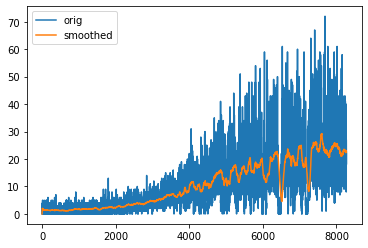

In [43]:
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  coord = tf.train.Coordinator()

  # Start worker threads
  worker_threads = []
  for worker in workers:
    worker_fn = lambda: worker.run(sess, coord, STEPS_PER_UPDATE)
    t = threading.Thread(target=worker_fn)
    t.start()
    worker_threads.append(t)

  # Wait for all workers to finish
  coord.join(worker_threads, stop_grace_period_secs=300)

  # Plot the smoothed returns
  x = np.array(returns_list)
  y = smooth(x)
  plt.plot(x, label='orig')
  plt.plot(y, label='smoothed')
  plt.legend()
  plt.show()